## Tourmaline toolkit in R - 16S & 18S-ITS Full Lake Erie Dataset 
 Updated: 9/28/2020
 
 Written by: Sean Anderson

This R notebook presents an example of importing and visualizing Tourmaline output files (data and taxonomy files) in R and uses common R packages for visualizing amplicon sequencing data (e.g. phyloseq; McMurdie and Holmes 2013). This dataset contains samples collected from Western Lake Erie in 2018. Separate loci (16S and 18S-ITS) were sequenced from these samples, allowing characterization of the bacterial and fungal community. This example workflow will include code on how to input .qza files into R, build a sampling map using ggplot2, and build diversity and taxonomy bar plots in R. Figures produced in this workflow are shown in Figure 3 in the manuscript. For this example dataset, only 5 um filter size samples will be processed and samples will be partitioned by sampling region. 

Upload R packages needed for this workflow.

In [2]:
library(qiime2R)
library(dplyr)
library(tidyr)
library(phyloseq)
library(tibble)
library(ggplot2)
library(sf)
library(raster)
library(ggspatial)
library(rnaturalearth)
library(rnaturalearthdata)
library(readr)
library(fantaxtic)
library(RColorBrewer)

Build a map (layer by layer) of the sampling region in Lake Erie using spatial mapping packages in R. Upload GIS shapefiles specific to the Great Lakes (available via open access GIS data) and use ggplot2 for layering of maps and sampling points (based on sample coordinates included in the the metadata file). 

In [3]:
# Upload shapefile for Great Lakes (http://gis-michigan.opendata.arcgis.com) and sampling point information taken from the metadata file - these are the layers!
gl_sf <- st_read("./Great_Lakes-shp/Great_Lakes.shp")
erie_sites <- read.csv("lake_sites.csv", header = T, row.names = NULL, check.names = F, fileEncoding = "UTF-8-BOM")
world <- ne_countries(scale = "medium", returnclass = "sf")


Reading layer `Great_Lakes' from data source `/Users/sean.r.anderson/16S_erie/Great_Lakes-shp/Great_Lakes.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 4 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -92.31441 ymin: 41.38462 xmax: -75.65701 ymax: 49.01483
geographic CRS: NAD83


Plot maps layer-by-layer using ggplot2. The world map is plotted first, followed by the Great Lakes map, and finally the sample sites from the metadata. The ggplot2 package allows flexibility in customizing you're map (e.g. color palettes, font sizes, axes labels, etc.)

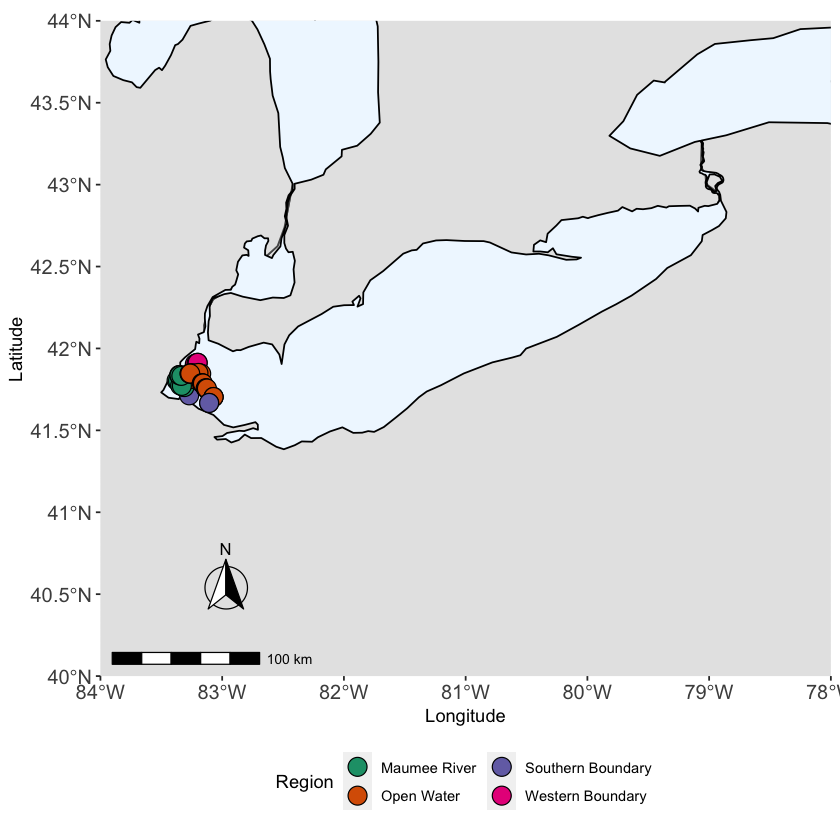

In [3]:
map <- ggplot(data = world) + geom_sf() + annotation_scale(location = "bl", width_hint = 0.3) +
    annotation_north_arrow(location = "bl", which_north = "true", pad_x = unit(0.75, "in"), pad_y = unit(0.5, "in"), style = north_arrow_fancy_orienteering) +
    geom_sf(data = gl_sf, fill = "aliceblue", color = "black") + coord_sf(xlim = c(-84, -78), ylim = c(40, 44), expand = FALSE) + xlab ("Longitude") + 
    ylab("Latitude") + geom_point(data = erie_sites, aes(x = Long, y = Lat, fill = Region), size = 5, shape = 21, colour = "black") +
    scale_fill_brewer(palette = "Dark2") + theme(legend.position="bottom") + guides(fill=guide_legend(nrow=2)) + theme(axis.text.y=element_text(size=12)) + theme(axis.text.x=element_text(size=12))
    
plot(map)

# Use ggsave to export any figure produced from ggplot2. Figures can be saved as tiff, png, jpeg, or eps file formats.
#ggsave(filename = "map_erie.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   

Using ggplot2, zoom in to better examine spatial differences in sampling regions by changing the xlim and ylim settings that correspond to coordinates on the map. 

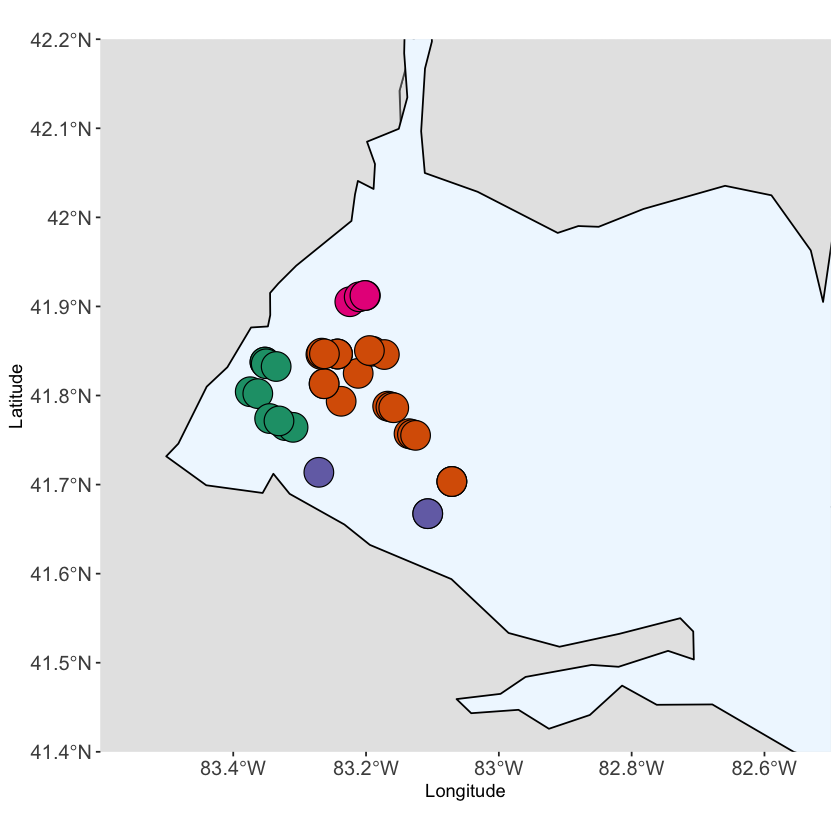

In [4]:
map_zoom <- ggplot(data = world) + geom_sf() + geom_sf(data = gl_sf, fill = "aliceblue", color = "black") + 
          coord_sf(xlim = c(-83.6, -82.5), ylim = c(41.4, 42.2), expand = FALSE) + xlab("Longitude") + ylab ("Latitude") +
          geom_point(data = erie_sites, aes(x = Long, y = Lat, fill = Region), size = 8, shape = 21, colour = "black") +
          scale_fill_brewer(palette = "Dark2") + theme(legend.position="none") + theme(axis.text.y=element_text(size=12)) + theme(axis.text.x=element_text(size=12))


plot(map_zoom)
#ggsave(filename = "map_erie_zoom.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)    

To explore amplicon data in R, the qiime2R package is used, which in this case, uploads QIIME 2 artifact files (.qza files) from the Tourmaline output into R. For this workflow, only the taxonomy and count table are uploaded, though other .qza files produced from Tourmaline (e.g. phylogenetic trees or representative sequences files) can be uploaded using the same approach. Note, the read_qza in qiime2R function requires the user to specify the file path which corresponds to the location of the Tourmaline output for each respective .qza file.

In [4]:
ASVtable_16S <- read_qza(file="/Users/sean.r.anderson/Tourmaline/tourmaline-test-09082020/02-output-dada2-pe/00-table-repseqs/table.qza")
ASVtable_16S <- ASVtable_16S$data
ASVtaxa_16S <- read_qza(file="/Users/sean.r.anderson/Tourmaline/tourmaline-test-09082020/02-output-dada2-pe/01-alignment-tree-taxonomy/taxonomy.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"))
taxtable_16S$Consensus <- NULL

# Clean up the taxonomy table a bit: remove unassigned reads at the Kingdom level and relabel taxa to remove unnecessary text (e.g. p__Proteobacteria becomes Proteobacteria)
taxtable_16S <- subset(taxtable_16S, !grepl("Unassigned",taxtable_16S$Kingdom))
taxtable_16S$Kingdom <- gsub("^.{0,3}", "", taxtable_16S$Kingdom)
taxtable_16S$Phylum <- gsub("^.{0,4}", "", taxtable_16S$Phylum)
taxtable_16S$Class <- gsub("^.{0,4}", "", taxtable_16S$Class)
taxtable_16S$Order <- gsub("^.{0,4}", "", taxtable_16S$Order)
taxtable_16S$Family <- gsub("^.{0,4}", "", taxtable_16S$Family)
taxtable_16S$Genus <- gsub("^.{0,4}", "", taxtable_16S$Genus)
taxtable_16S$Species <- gsub("^.{0,4}", "", taxtable_16S$Species)


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 11760 rows [6, 7, 8, 9, 13, 18, 20, 22, 24, 25, 26, 27, 29, 30, 32, 33, 35, 36, 37, 39, ...].”


Upload sample metadata file used in the Tourmaline run.  

In [5]:
sample_info_tab <- read.table(file="/Users/sean.r.anderson/Tourmaline/tourmaline-test-09082020/00-data/metadata_16S.tsv", header=TRUE, row.names=1, sep="\t", na.strings = c("", "NA"))

Merge everything together into a phyloseq object and rename taxa to something easier to understand (e.g. ASV 1, ASV 2, etc.). The phyloseq object will have the taxonomy, count, and metadata files all included, which will make it easy to subset the data (e.g. remove unwanted taxa) or plot data based on factors in the metadata (e.g. in this case by sampling region). 

In [6]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T), tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>% as.matrix()), sample_data(sample_info_tab))

taxa_names(physeq_16S) <- paste0("ASV", seq(ntaxa(physeq_16S)))

Clean up the 16S dataset, removing taxa that do not have a defined region (e.g. the controls), samples that have anomalously low read numbers (SC45), and any other filtering needs that may vary depending on analyses (e.g. remove Chloroplast and Mitochondria sequences). These are only a few of the filtering options available to users in phyloseq. 

In [7]:
psnew_16S = subset_samples(physeq_16S, region != "NA")
psnew_16S = subset_samples(psnew_16S, sample_name_water != "SC45")
psnew_16S = subset_taxa(psnew_16S, Order != "Chloroplast" & Family !="Mitochondria")                    

Samples were collected on two filter sizes (0.22 and 5 um) for each site. For this workflow, we focus only on the 5 um size samples, subsetting from the phyloseq object based on a metadata variable (filter_size). 

In [8]:
ps5_16S <- subset_samples(psnew_16S, filter_size == "5.0um")

Using phyloseq, plot the Shannon alpha diversity values for 16S samples and group by sampling region. Before plotting, rarefy the samples to the lowest read number in the dataset. Note, Tourmaline produces a rarefied and unrarefied data table, which allows the user flexibility in post-processing and analysis.

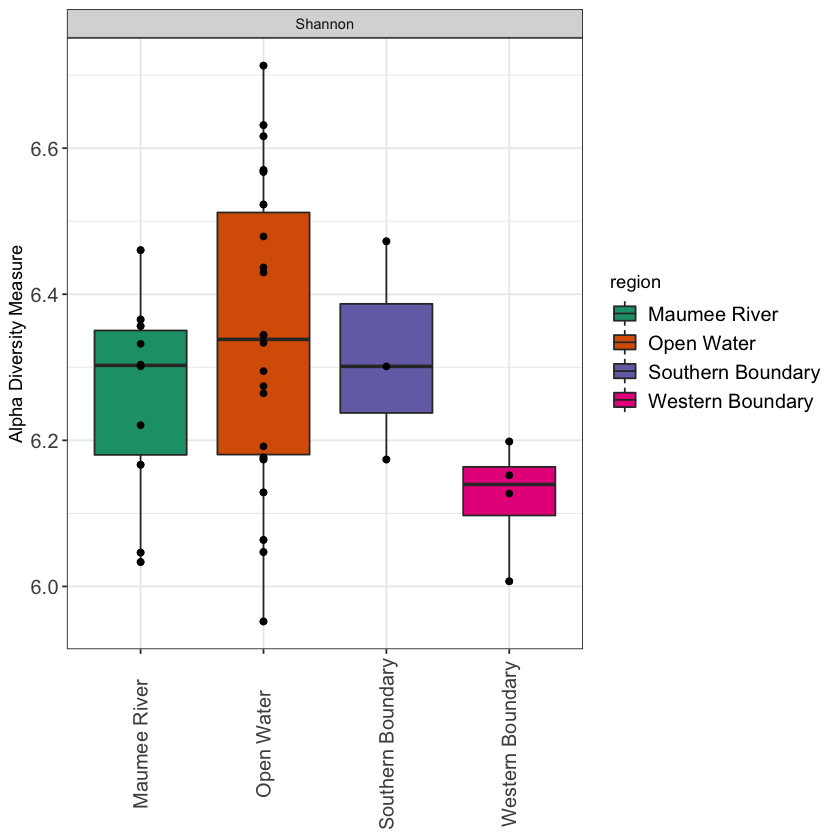

In [9]:
suppressMessages(ps5_rarefy_16S <- rarefy_even_depth(ps5_16S, sample.size = min(sample_sums(ps5_16S)), rngseed = 714, replace = TRUE, trimOTUs = TRUE, verbose = TRUE))
p_alpha <- plot_richness(ps5_rarefy_16S, x = "region", measures=("Shannon")) # Option to change Shannon and plot the Observed richness, Simpson, or Chao1 metrics instead or in addition to.
p_alpha + geom_boxplot(aes(fill = region)) + geom_point()+ scale_fill_brewer(palette="Dark2") +theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, size=12)) + theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+theme(axis.title.x = element_blank()) 

options(repr.plot.width=8, repr.plot.height=5) 
#ggsave(filename = "16S_alpha.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   

Run an NMDS ordination on the 16S data and plot the ordination using phyloseq. Beta diversity analyses in phyloseq wrap in the vegan package (Oksanen 2019). For this set, we will exclude global singletons (ASVs only found once in the set) and transform the data to relative abundance. Samples are colored by region using the same color palette. 

Run 0 stress 0.09137343 
Run 1 stress 0.09081743 
... New best solution
... Procrustes: rmse 0.01995281  max resid 0.09235814 
Run 2 stress 0.09847183 
Run 3 stress 0.0908176 
... Procrustes: rmse 3.810708e-05  max resid 0.0001250979 
... Similar to previous best
Run 4 stress 0.09858961 
Run 5 stress 0.09081746 
... Procrustes: rmse 2.861004e-05  max resid 7.39061e-05 
... Similar to previous best
Run 6 stress 0.09081744 
... Procrustes: rmse 1.067663e-05  max resid 2.578423e-05 
... Similar to previous best
Run 7 stress 0.09859219 
Run 8 stress 0.0956546 
Run 9 stress 0.09120134 
... Procrustes: rmse 0.009003674  max resid 0.04693836 
Run 10 stress 0.09850932 
Run 11 stress 0.09849644 
Run 12 stress 0.09153884 
Run 13 stress 0.09137301 
Run 14 stress 0.09153884 
Run 15 stress 0.09855684 
Run 16 stress 0.09560232 
Run 17 stress 0.09850938 
Run 18 stress 0.09137307 
Run 19 stress 0.09153889 
Run 20 stress 0.0912026 
... Procrustes: rmse 0.008440833  max resid 0.04428749 
*** Solution re

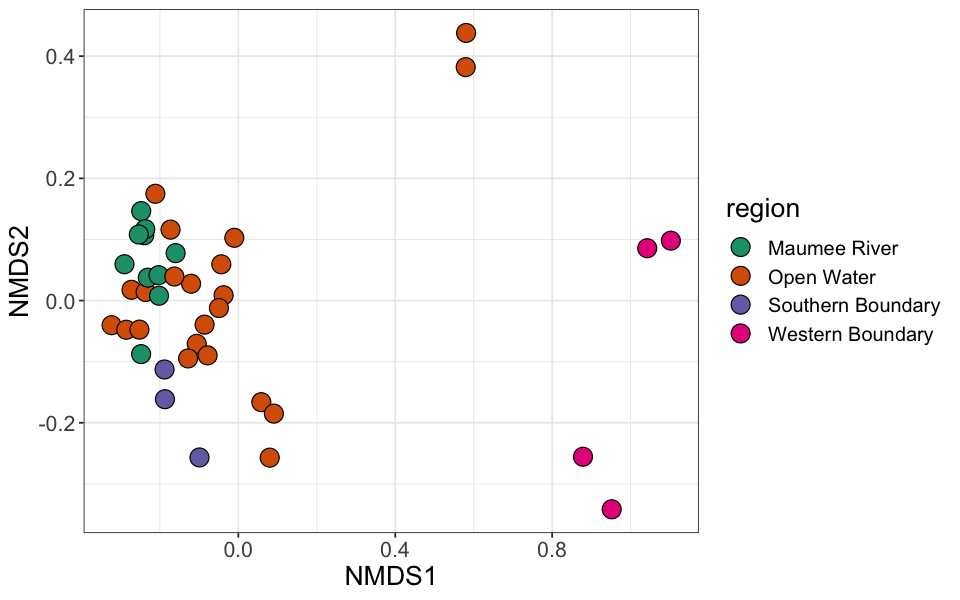

In [10]:
ps5_rarefy_16S = filter_taxa(ps5_rarefy_16S, function (x) {sum(x) > 1}, prune=TRUE)
ps_16S_rel  <- transform_sample_counts(ps5_rarefy_16S,function(x) x/sum(x))
ps_16S_ord  <- ordinate(ps_16S_rel, "NMDS", "bray")
p_beta = plot_ordination(ps_16S_rel, ps_16S_ord, color="region") + guides(color=FALSE)
p_beta + theme_bw() + theme(text = element_text(size = 16)) + geom_point(aes(fill=region),size = 5, shape = 21, colour = "black") + scale_fill_brewer(palette="Dark2") + theme(legend.text = element_text(colour="black", size=12))  

options(repr.plot.width=8, repr.plot.height=5)                                        
#ggsave(filename = "16S_nmds.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   

Plot stacked taxonomY bar plots of the top 16S taxa groups at the Class level (similar approach used for any other taxonomic level). Taxa that are < 5% in any given sample are grouped into an "other" category. Samples are faceted based on the sampling region in Lake Erie. Facets are an included function within the ggplot2 package. Bar plots can be heavily customized using ggplot2. Additional steps used here are annotated along with the code to provide context for 16S bar plots. 

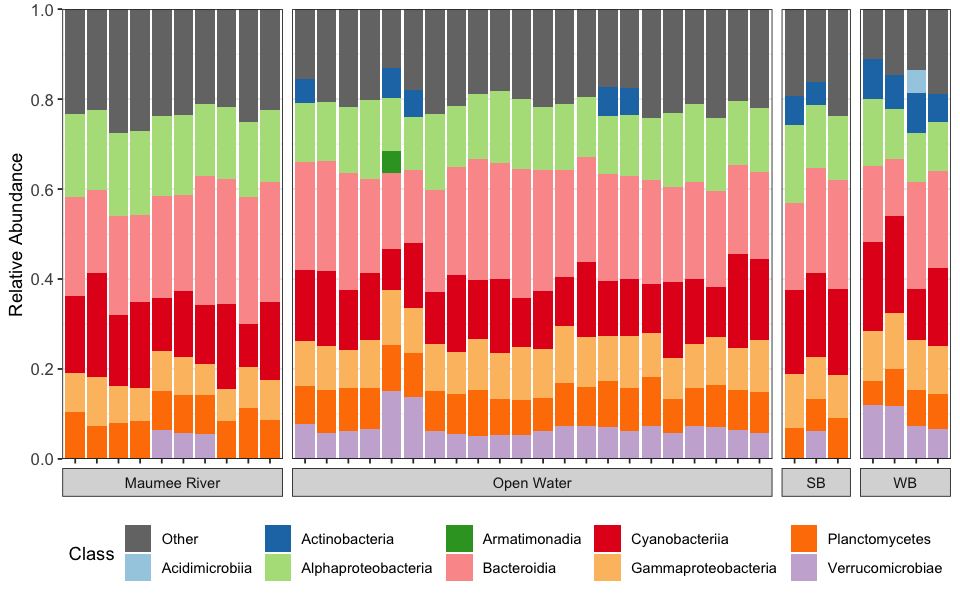

In [11]:
x1 <- tax_glom(ps5_rarefy_16S, taxrank = 'Class', NArm=FALSE) # Agglomerate to Class level
x2 <- transform_sample_counts(x1, function(x) x/sum(x)) # Transform to relative abundance
x3 <- psmelt(x2) # Melt the data to long format
x3$Class<- as.character(x3$Class) # Convert to character
x3$Class[x3$Abundance < 0.05]= "Other" # Establish "other" category

p_taxa <- ggplot(data=x3, aes(x= sample_station, y=Abundance, fill=Class))

# Control the order of taxa that show up in the bar plots and create a color palette based on # of colors needed (10 in this case).
p_taxa$data$Class <- factor(p_taxa$data$Class, levels = c("Other", "Acidimicrobiia", "Actinobacteria", "Alphaproteobacteria", "Armatimonadia", "Bacteroidia", "Cyanobacteriia", "Gammaproteobacteria", "Planctomycetes","Verrucomicrobiae"))
mycolors = c("#757575", brewer.pal(name="Paired", n = 12))

# New facet label names for sampling regions
regions.labs <- c("Maumee River", "Open Water", "SB", "WB")
names(regions.labs) <- c("Maumee River", "Open Water", "Southern Boundary", "Western Boundary")

# Plot bar plots
p_taxa + geom_bar(stat="identity", position = "stack")+scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.2), limits=c(0, 1)) + geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values=mycolors)+ theme(axis.text.x=element_text(angle=90,vjust=0.5, size=10)) + theme(axis.text.y=element_text(size=10))+ theme(legend.position="bottom") +
theme(axis.text.x = element_blank()) + guides(fill=guide_legend(nrow=2)) + theme(axis.title.x=element_blank())+ labs(y = "Relative Abundance") + facet_grid(~region, labeller = labeller(region = regions.labs), scales = "free_x", space = "free", switch = "x")+ theme(strip.placement = "outside")

                              
options(repr.plot.width=8, repr.plot.height=5)   
#ggsave(filename = "16S_taxa_plot.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 10, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   

Read in the .qza files from the 18S-ITS Tourmaline run. Note, the different file path that corresponds to a separate run. The code to build plots will be similar to the 16S processing.  

In [12]:
ASVtable_18S <- read_qza(file="/Users/sean.r.anderson/Tourmaline/tourmaline-2018-its-sep2020/02-output-dada2-se/00-table-repseqs/table.qza")
ASVtable_18S <- ASVtable_18S$data
ASVtaxa_18S <- read_qza(file="/Users/sean.r.anderson/Tourmaline/tourmaline-2018-its-sep2020/02-output-dada2-se/01-alignment-tree-taxonomy/taxonomy.qza")
taxtable_18S <- ASVtaxa_18S$data %>% as_tibble() %>% separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"))
taxtable_18S$Confidence <- NULL

# Clean up the taxonomy table a bit: remove unassigned reads at the Kingdom level and relabel taxa to remove unnecessary text (e.g. p__Ciliophora becomes Ciliophora)
taxtable_18S <- subset(taxtable_18S, !grepl("Unassigned",taxtable_18S$Kingdom))
taxtable_18S$Kingdom <- gsub("^.{0,3}", "", taxtable_18S$Kingdom)
taxtable_18S$Phylum <- gsub("^.{0,3}", "", taxtable_18S$Phylum)
taxtable_18S$Class <- gsub("^.{0,3}", "", taxtable_18S$Class)
taxtable_18S$Order <- gsub("^.{0,3}", "", taxtable_18S$Order)
taxtable_18S$Family <- gsub("^.{0,3}", "", taxtable_18S$Family)
taxtable_18S$Genus <- gsub("^.{0,3}", "", taxtable_18S$Genus)
taxtable_18S$Species <- gsub("^.{0,3}", "", taxtable_18S$Species)

# Convert unidentified taxa to "NA". This will help us deal with high amounts of unassigned taxa when making bar plots. 
taxtable_18S[taxtable_18S=="unidentified"]<-NA

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 3980 rows [3, 5, 15, 18, 19, 22, 27, 30, 35, 37, 38, 42, 43, 45, 48, 50, 52, 54, 55, 56, ...].”


Read in your metadata file. For this workflow, the 16S and 18S-ITS share the same metadata, so the previously uploaded file (erie_metadata_16S.tsv) can be used again as input into our 18S-ITS phyloseq object. 

In [13]:
physeq_18S <- phyloseq(otu_table(ASVtable_18S, taxa_are_rows= T), tax_table(as.data.frame(taxtable_18S) %>% column_to_rownames("Feature.ID") %>% as.matrix()), sample_data(sample_info_tab))
taxa_names(physeq_18S) <- paste0("ASV", seq(ntaxa(physeq_18S)))

Clean up the dataset, removing samples without a region (controls) and sample SC45. 

In [14]:
psnew_18S = subset_samples(physeq_18S, region != "NA")
psnew_18S = subset_samples(psnew_18S, sample_name_water != "SC45")

Subset to 5 um filter size. 

In [15]:
ps5_18S <- subset_samples(psnew_18S, filter_size == "5.0um")

Run alpha diversity with the subsetted 18S-ITS samples. 

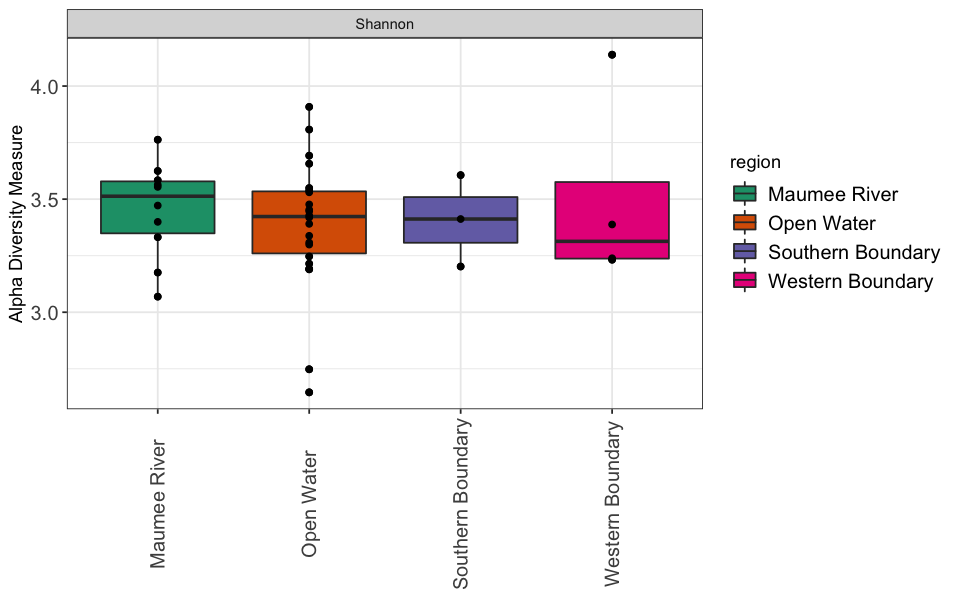

In [16]:
suppressMessages(ps5_rarefy_18S <- rarefy_even_depth(ps5_18S, sample.size = min(sample_sums(ps5_18S)), rngseed = 714, replace = TRUE, trimOTUs = TRUE, verbose = TRUE))
p_alpha_18S <- plot_richness(ps5_rarefy_18S, x = "region", measures=("Shannon")) 
p_alpha_18S + geom_boxplot(aes(fill = region)) + geom_point()+ scale_fill_brewer(palette="Dark2") +theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, size=12)) + theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+theme(axis.title.x = element_blank()) 

options(repr.plot.width=8, repr.plot.height=5) 
#ggsave(filename = "18S_alpha.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)

Run an NMDS with the 18S-ITS data. 

Run 0 stress 0.09152988 
Run 1 stress 0.08333714 
... New best solution
... Procrustes: rmse 0.05559257  max resid 0.2157066 
Run 2 stress 0.0851073 
Run 3 stress 0.0851113 
Run 4 stress 0.08895363 
Run 5 stress 0.08645157 
Run 6 stress 0.08600752 
Run 7 stress 0.3982731 
Run 8 stress 0.08510782 
Run 9 stress 0.3817395 
Run 10 stress 0.08646674 
Run 11 stress 0.08641307 
Run 12 stress 0.08511604 
Run 13 stress 0.08300926 
... New best solution
... Procrustes: rmse 0.008441261  max resid 0.03303641 
Run 14 stress 0.08331743 
... Procrustes: rmse 0.0066677  max resid 0.03027161 
Run 15 stress 0.08334351 
... Procrustes: rmse 0.00876059  max resid 0.03349362 
Run 16 stress 0.09205863 
Run 17 stress 0.09094877 
Run 18 stress 0.08568574 
Run 19 stress 0.08510632 
Run 20 stress 0.09204447 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


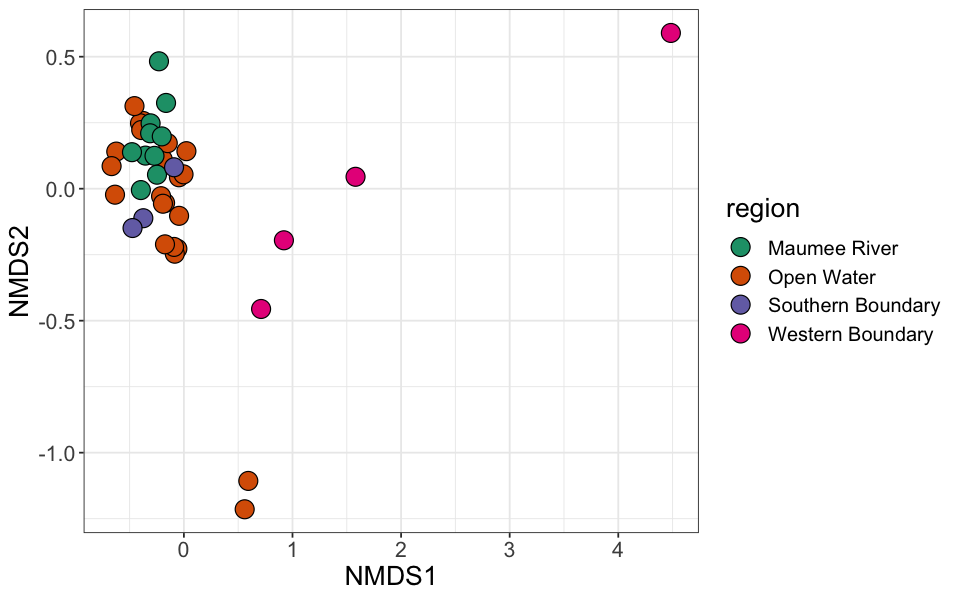

In [17]:
ps5_rarefy_18S = filter_taxa(ps5_rarefy_18S, function (x) {sum(x) > 1}, prune=TRUE)
ps_18S_rel  <- transform_sample_counts(ps5_rarefy_18S,function(x) x/sum(x))
ps_18S_ord  <- ordinate(ps_18S_rel, "NMDS", "bray")
p_beta_18S = plot_ordination(ps_18S_rel, ps_18S_ord, color="region") + guides(color=FALSE)
p_beta_18S + theme_bw() + theme(text = element_text(size = 16)) + geom_point(aes(fill=region),size = 5, shape = 21, colour = "black") + scale_fill_brewer(palette="Dark2") + theme(legend.text = element_text(colour="black", size=12))

options(repr.plot.width=8, repr.plot.height=5)                                        
#ggsave(filename = "18S_nmds.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)

Stacked taxonomy bar plots at class-level. 

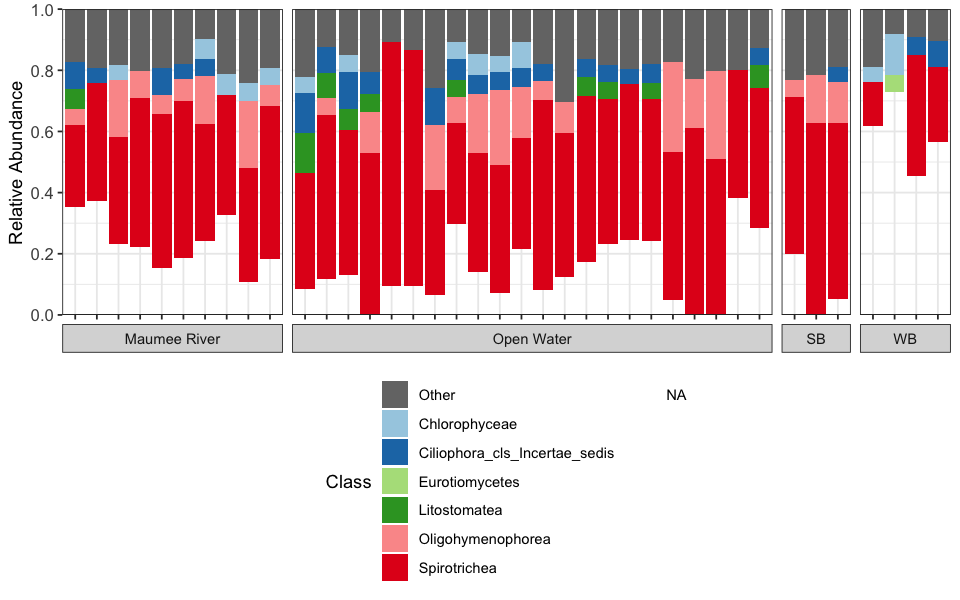

In [18]:
x1 <- tax_glom(ps5_rarefy_18S, taxrank = 'Class', NArm=FALSE)
x2 <- transform_sample_counts(x1, function(x) x/sum(x)) 
x3 <- psmelt(x2)
x3$Class<- as.character(x3$Class) 
x3$Class[x3$Abundance < 0.05]= "Other"
p_taxa_18S <- ggplot(data=x3, aes(x= sample_station, y=Abundance, fill=Class))

# Control the order of taxa that show up in the bar plots and create a color palette based on # of colors needed (13 in this case).
p_taxa_18S$data$Class <- factor(p_taxa_18S$data$Class, levels = c("Other", "Chlorophyceae", "Chytridiomycetes", "Ciliophora_cls_Incertae_sedis", "Eurotiomycetes", "Litostomatea", "Oligohymenophorea", "Spirotrichea", "NA"))
mycolors = c("#757575", brewer.pal(name="Paired", n = 12))

# Change to desired facet labels
regions.labs <- c("Maumee River", "Open Water", "SB", "WB")
names(regions.labs) <- c("Maumee River", "Open Water", "Southern Boundary", "Western Boundary")                              

p_taxa_18S + geom_bar(stat="identity", position = "stack")+scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.2), limits=c(0, 1)) + geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values = mycolors)+ theme(axis.text.x=element_text(angle=90,vjust=0.5, size=10)) + theme(axis.text.y=element_text(size=10))+ theme(legend.position="bottom") +
theme(axis.text.x = element_blank()) + guides(fill=guide_legend(nrow=7)) + theme(axis.title.x=element_blank())+ labs(y = "Relative Abundance") + facet_grid(~region, labeller = labeller(region = regions.labs), scales = "free_x", space = "free", switch = "x")+ theme(strip.placement = "outside")
                              
options(repr.plot.width=8, repr.plot.height=5) 

A good percentage of taxa at the class level are unassigned (NA). We can use a package called fantaxtic, which uses a function to label all the unassigned taxa (e.g. NA in the taxonomy table) to their deepest possible annotation (e.g. Unassigned Alveolata). This way, we can make a bit more sense out of the unidentified taxa in our dataset! 

In [19]:
ps5_rarefy_18S <- name_taxa(ps5_rarefy_18S, label = "Unassigned")

Repeat the bar plots with new annotation scheme. 

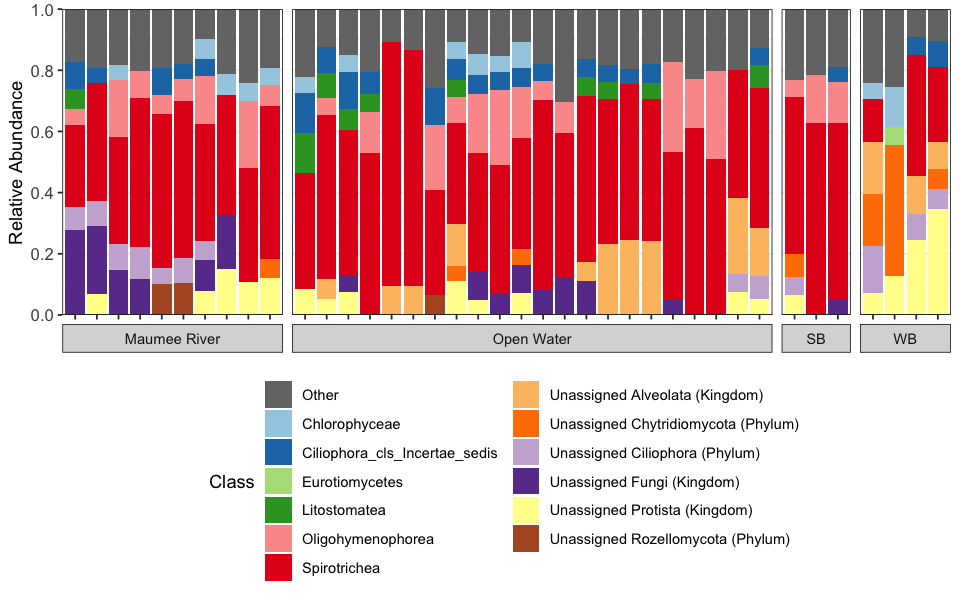

In [20]:
x1 <- tax_glom(ps5_rarefy_18S, taxrank = 'Class', NArm=FALSE)
x2 <- transform_sample_counts(x1, function(x) x/sum(x)) 
x3 <- psmelt(x2)
x3$Class<- as.character(x3$Class) 
x3$Class[x3$Abundance < 0.05]= "Other"
p_taxa_18S <- ggplot(data=x3, aes(x= sample_station, y=Abundance, fill=Class))

# Control the order of taxa that show up in the bar plots and create a color palette based on # of colors needed (13 in this case).
p_taxa_18S$data$Class <- factor(p_taxa_18S$data$Class, levels = c("Other", "Chlorophyceae", "Ciliophora_cls_Incertae_sedis", "Eurotiomycetes", "Litostomatea", "Oligohymenophorea", "Spirotrichea", "Unassigned Alveolata (Kingdom)", "Unassigned Chytridiomycota (Phylum)", "Unassigned Ciliophora (Phylum)", "Unassigned Fungi (Kingdom)", "Unassigned Protista (Kingdom)", "Unassigned Rozellomycota (Phylum)"))
mycolors = c("#757575", brewer.pal(name="Paired", n = 12))

# Change to desired facet labels
regions.labs <- c("Maumee River", "Open Water", "SB", "WB")
names(regions.labs) <- c("Maumee River", "Open Water", "Southern Boundary", "Western Boundary")                                                            
                              
p_taxa_18S + geom_bar(stat="identity", position = "stack")+scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.2), limits=c(0, 1)) + geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values = mycolors)+ theme(axis.text.x=element_text(angle=90,vjust=0.5, size=10)) + theme(axis.text.y=element_text(size=10))+ theme(legend.position="bottom") +
theme(axis.text.x = element_blank()) + guides(fill=guide_legend(nrow=7)) + theme(axis.title.x=element_blank())+ labs(y = "Relative Abundance") + facet_grid(~region, labeller = labeller(region = regions.labs), scales = "free_x", space = "free", switch = "x")+ theme(strip.placement = "outside")

options(repr.plot.width=8, repr.plot.height=5)                               
#ggsave(filename = "18S_taxa_plot.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 10, height = 5, units = c("in", "cm", "mm"), dpi = 600)  